In [41]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import random

import numpy as np

import matplotlib.cm as cm

import pickle

from denoising_assessment_project.utils import metric_compute, stats_compute, stats_plot

# parameters setup 
from denoising_assessment_project.global_vars import global_vars

%matplotlib notebook

In [42]:
global_vars.init()

In [43]:
# -PARAMETERS FOR GENERATION-

# image dimensions
#global_vars.image_dimensions = torch.Size([256,256])

# reps in a series 
#global_vars.series_size = 1000

#global_vars.blobs_population_sizes = torch.tensor([3,30,300])
#global_vars.peak_values = torch.tensor([10,100,1000])

# VARIED BACKGROUND BY MIMICKING LASER BEAM:
# image dimensions
#global_vars.image_dimensions = torch.Size([256,256])
# reps in a series 
#global_vars.series_size = 1000
#global_vars.blobs_population_sizes = torch.tensor([3,30,90,150,210,300])
#global_vars.peak_values = torch.tensor([10,50,100,200,500,1000])

# VARIED BACKGROUND BY MIMICKING LASER BEAM - ZOOMED:
# image dimensions
#global_vars.image_dimensions = torch.Size([256,256])
# reps in a series 
#global_vars.series_size = 500
#global_vars.blobs_population_sizes = torch.tensor([3,30,90,150,210,300])
#global_vars.peak_values = torch.arange(10,200,37)

# ZOOM ZOOM for further N2V investigation:
# image dimensions
global_vars.image_dimensions = torch.Size([256,256])
# reps in a series
global_vars.series_size = 500
global_vars.blobs_population_sizes = torch.arange(150,300,29)
global_vars.peak_values = torch.arange(90,200,20)

# for test runs: 
# image dimensions
#global_vars.image_dimensions = torch.Size([256,256])

# reps in a series 
#global_vars.series_size = 10

#global_vars.blobs_population_sizes = torch.tensor([30])
#global_vars.peak_values = torch.tensor([100])

In [44]:
print(global_vars.blobs_population_sizes.shape)
print(global_vars.peak_values.shape)

print(global_vars.blobs_population_sizes)
print(global_vars.peak_values)

torch.Size([6])
torch.Size([6])
tensor([150, 179, 208, 237, 266, 295])
tensor([ 90, 110, 130, 150, 170, 190])


<IPython.core.display.Javascript object>


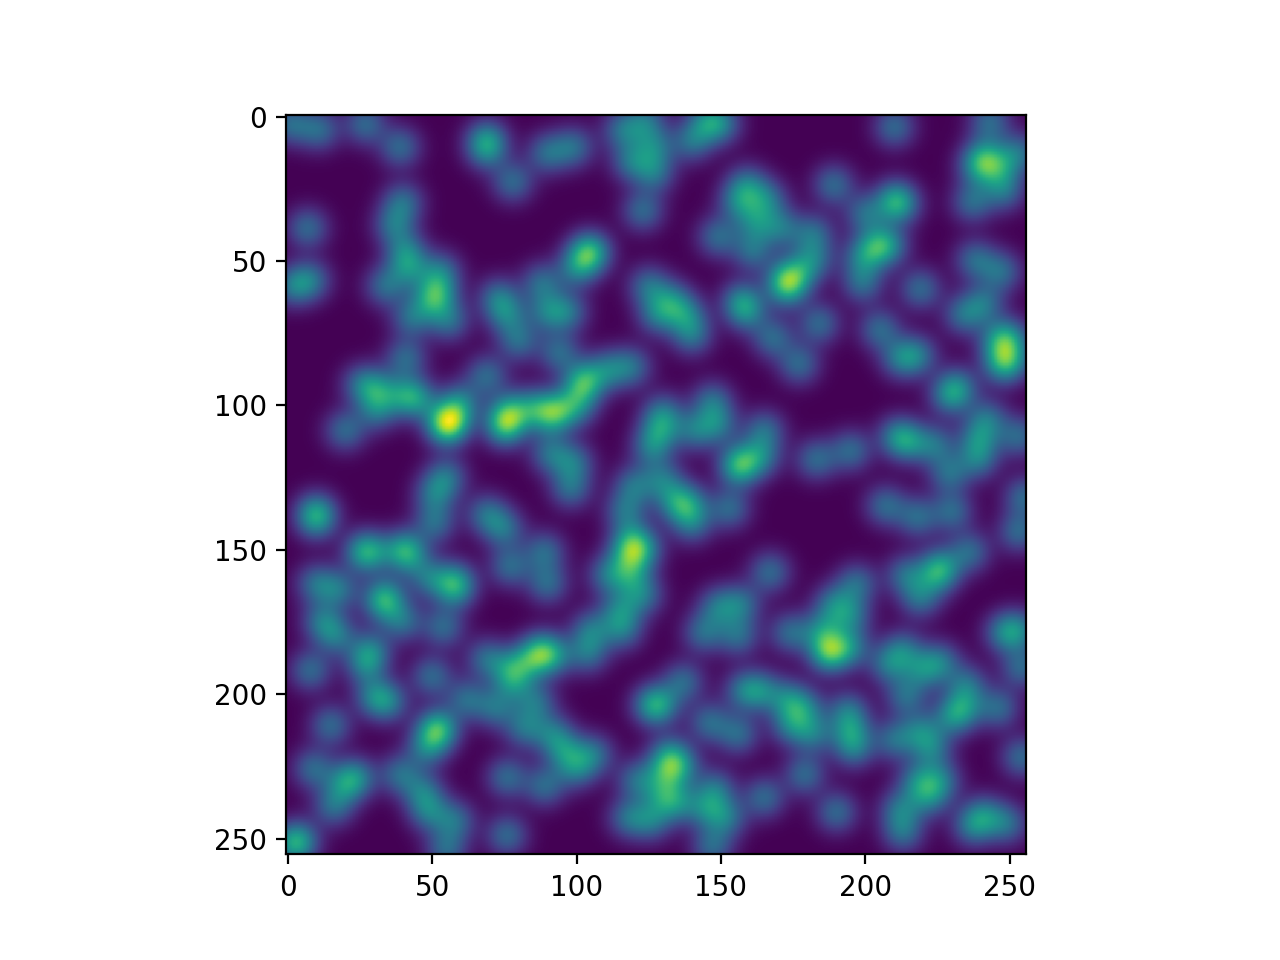

torch.Size([6, 500, 256, 256])
tensor(2.9396e-38)
tensor(6.1564)


In [45]:
# -TRAINING IMAGES GENERATION-

# 1. Generating n sets of randomly located blobs for varying quantities of blobs 
# (n = len(blobs_population_sizes))
# dims=[n, reps, img_x, img_y]
distinct_blob_quantities_td_beam_zoom_zoom = data_gen_default.varying_blob_quantities_img_series_generate(global_vars.series_size, global_vars.blobs_population_sizes, global_vars.image_dimensions)
# tests 
print(distinct_blob_quantities_td_beam_zoom_zoom.shape)
print(distinct_blob_quantities_td_beam_zoom_zoom.min())
print(distinct_blob_quantities_td_beam_zoom_zoom.max())

# 2. Generating m sets of images with different peak values and applying poisson noise to them 
# (m = len(peak_values))
# dims=[2, m, n, reps, img_x, img_y]
# 2a. 
distinct_peaks_and_blob_quantities_td_beam_zoom_zoom = data_gen.varying_peak_values_apply(distinct_blob_quantities_td_beam_zoom_zoom, global_vars.peak_values)
# 2b.
un_noised_images_td_beam_zoom_zoom = data_gen.background_offset_apply(distinct_peaks_and_blob_quantities_td_beam_zoom_zoom, 10)
# 2c.
un_noised_images_td_beam_zoom_zoom = data_gen.gaussian_beam_apply(un_noised_images_td_beam_zoom_zoom)
# 2d.
noised_images_td_beam_zoom_zoom = data_gen.noise_apply(un_noised_images_td_beam_zoom_zoom)

# 3. Generating indices for m peak values and n blob quantities reflective of the arragngement of the n x m sets 
# dims=[2, m, n]
indices_td_zoom_zoom = data_gen_default.indices_generate(noised_images_td_beam_zoom_zoom)

In [46]:
# storing generated data
noised_images_td_beam_zoom_zoom_pickled = pickle.dump(noised_images_td_beam_zoom_zoom, open("/Users/miriamczech/Desktop/denoising_assessment/pickled_data/training_data/noised_images_td_beam_zoom_zoom.pkl", 'wb'), protocol=4)
%store noised_images_td_beam_zoom_zoom_pickled

un_noised_images_td_beam_zoom_zoom_pickled = pickle.dump(un_noised_images_td_beam_zoom_zoom, open("/Users/miriamczech/Desktop/denoising_assessment/pickled_data/training_data/un_noised_images_td_beam_zoom_zoom.pkl", 'wb'), protocol=4)
%store un_noised_images_td_beam_zoom_zoom_pickled

%store indices_td_zoom_zoom

Stored 'noised_images_td_beam_zoom_zoom_pickled' (NoneType)
Stored 'un_noised_images_td_beam_zoom_zoom_pickled' (NoneType)
Stored 'indices_td_zoom_zoom' (Tensor)


In [2]:
#%store -r

In [3]:
# for N2N training we need two noised instances of each image 

#with open("/Users/miriamczech/Desktop/denoising_assessment/pickled_data/training_data/un_noised_images_td_beam_zoom.pkl", 'rb') as un_noised_images_td_beam_zoom_pickled:
    #un_noised_images = pickle.load(un_noised_images_td_beam_zoom_pickled)

# 2d.
#noised_images_td_beam_zoom_2 = data_gen.noise_apply(un_noised_images)

In [4]:
#un_noised_images_td_beam_zoom_2_pickled = pickle.dump(noised_images_td_beam_zoom_2, open("/Users/miriamczech/Desktop/denoising_assessment/pickled_data/training_data/noised_images_td_beam_zoom_2.pkl", 'wb'), protocol=4)
#%store un_noised_images_td_beam_zoom_2_pickled

Stored 'un_noised_images_td_beam_zoom_2_pickled' (NoneType)


In [47]:
import os
from tifffile import imwrite

example_img_GT = un_noised_images_td_beam_zoom_zoom[1,1,1,:,:]
im = np.asarray(example_img_GT.numpy().astype(np.single))
imwrite('ex_img_GT.tif', im)

example_img_low = noised_images_td_beam_zoom_zoom[1,1,1,:,:]
im = np.asarray(example_img_low.numpy().astype(np.single))
imwrite('ex_img_low.tif', im)

In [48]:
print(noised_images_td_beam_zoom_zoom.shape)
print(un_noised_images_td_beam_zoom_zoom.shape)

torch.Size([6, 6, 500, 256, 256])
torch.Size([6, 6, 500, 256, 256])


In [49]:
import os
from tifffile import imwrite

for n in range(noised_images_td_beam_zoom_zoom.shape[0]):
    for m in range(noised_images_td_beam_zoom_zoom.shape[1]):
        for i in range(noised_images_td_beam_zoom_zoom.shape[2]):
            print('n datatype:', type(n))
            print('m datatype:', type(m))
            print('i datatype:', type(i))
            im = np.asarray(noised_images_td_beam_zoom_zoom[n,m,i,:,:].numpy().astype(np.single))
            
            if n > 99:
                print('warning n')
            if m > 99:
                print('warning m')
            if i > 999:
                print('warning i')
            
            if n in range(0,10):
                n = '0{}'.format(n)
            if m in range(0,10):
                m = '0{}'.format(m)
            if i in range(0,10):
                i = '00{}'.format(i)
            if i in range(10,100):
                i = '0{}'.format(i)
            
            savepath = '/Users/miriamczech/Desktop/denoising_assessment/tiffed_data_beam/training_data/zoom_zoom/noised'
            filename = '{}_{}_{}.tif'.format(n,m,i)
            
            n = int(n)
            m = int(m)
            i = int(i)

            savename = os.path.join(savepath, filename)
            
            #photometric='minisblack'
            imwrite(savename, im)

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

In [50]:
import os
from tifffile import imwrite

for n in range(un_noised_images_td_beam_zoom_zoom.shape[0]):
    for m in range(un_noised_images_td_beam_zoom_zoom.shape[1]):
        for i in range(un_noised_images_td_beam_zoom_zoom.shape[2]):
            print('n datatype:', type(n))
            print('m datatype:', type(m))
            print('i datatype:', type(i))
            im = np.asarray(un_noised_images_td_beam_zoom_zoom[n,m,i,:,:].numpy().astype(np.single))
            
            if n > 99:
                print('warning n')
            if m > 99:
                print('warning m')
            if i > 999:
                print('warning i')
            
            if n in range(0,10):
                n = '0{}'.format(n)
            if m in range(0,10):
                m = '0{}'.format(m)
            if i in range(0,10):
                i = '00{}'.format(i)
            if i in range(10,100):
                i = '0{}'.format(i)
            
            savepath = '/Users/miriamczech/Desktop/denoising_assessment/tiffed_data_beam/training_data/zoom_zoom/un_noised'
            filename = '{}_{}_{}.tif'.format(n,m,i)
            
            n = int(n)
            m = int(m)
            i = int(i)

            savename = os.path.join(savepath, filename)
            
            #photometric='minisblack'
            imwrite(savename, im)

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 

n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: <class 'int'>
n datatype: <class 'int'>
m datatype: <class 'int'>
i datatype: 